In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import nltk
nltk.download('stopwords')


from tensorflow.keras.layers import Dense, LSTM, \
    Embedding, BatchNormalization, Attention, Dropout, ReLU, SpatialDropout1D

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import optimizers

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/panagiotis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Existing code was used from the links mention in the assignment

### Read data
Extract reviews from the related files and directories and form train and test datasets.
Implementation taken from https://github.com/iworeushankaonce

In [2]:
def data_load(data_dir):

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])

    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

# Only train dataset will be used which amounts to 25000 reviews
train, _ = data_load('aclImdb_v1/aclImdb/')

In [3]:
train_x, train_y = train['text'].tolist(), np.array(train['sentiment'])

### Data preprocessing

##### Convert to lowercase and remove punctuation

In [4]:
from string import punctuation

all_text = '\n'.join([c for c in train_x])
all_text = ''.join([c.lower() for c in all_text if c not in punctuation])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


##### Remove stopwords

In [5]:
all_text_words = all_text.split(' ')
stopwords = nltk.corpus.stopwords.words('english')
all_text_without_stopwords = [word for word in all_text_words if word not in stopwords]
all_text_final = ' '.join([c for c in all_text_without_stopwords])

In [6]:
reviews_split = all_text_final.split('\n')
print ('Number of reviews :', len(reviews_split))

Number of reviews : 25000


##### Find dataset vocabulary

In [7]:
from collections import Counter
all_text2 = ' '.join(reviews_split)

words = all_text2.split()
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

##### Assign ID to each word. Reserve 0 for padding
##### Convert words to IDs for each review

In [8]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)


[[7338, 7778, 15, 2096, 5, 59, 26204, 3429, 358, 2681, 57531, 4613, 559, 71, 17, 1229, 40, 1052, 103, 71, 294, 82, 3778, 414, 89, 158, 52, 9375, 2776, 195, 4395, 21143, 588, 118, 538, 974, 3075, 5, 7778, 75, 22533, 3384, 394, 1155, 103, 108, 7, 10769, 23, 83, 737, 3740, 491, 298, 83, 3741, 5102, 1471, 5273], [2559, 2238, 1273, 2747, 103, 670, 55, 5870, 51, 270, 36, 2, 774, 2920, 2502, 4109, 467, 2225, 66, 658, 433, 291, 9191, 399, 36, 1078, 1701, 2238, 375, 315, 9191, 148, 175, 397, 40, 71, 4192, 134, 643, 9376, 5563, 9377, 6445, 2730, 20, 1714, 2805, 3649, 175, 291, 237, 315, 1789, 6341, 1504, 5563, 106, 1050, 774, 234, 24, 7231, 1, 2, 139, 1273, 2747, 173, 757, 27, 12, 551, 88, 692, 2, 19, 12, 858, 722, 774, 5563, 7446, 58, 95, 214, 399, 72, 27, 6445, 2730, 2502, 4109, 558, 63, 98, 19, 244, 160, 2730, 1367, 363, 673, 302, 484, 127, 197, 3323, 807, 19, 69, 19, 2, 39, 327, 703, 6, 174], [2191, 43747, 49, 1710, 469, 1240, 7124, 2085, 2007, 15132, 18949, 3411, 4752, 2710, 538, 353, 55, 3

##### Extract statistics for reviews length

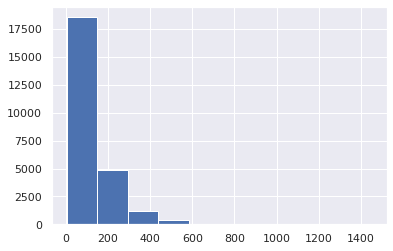

count    25000.000000
mean       125.042480
std         93.594474
min          5.000000
25%         67.000000
50%         93.000000
75%        152.000000
max       1449.000000
dtype: float64

In [9]:
%matplotlib inline
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

##### Set max review length, pad with zeros and divide dataset into train-val-test sets

In [10]:
max_review_length = 152
features = sequence.pad_sequences(reviews_int, maxlen=max_review_length)
labels = train_y.reshape(-1,1)

split_frac = .9
len_feat = features.__len__()
train_x = features[0:int(split_frac*len_feat)]
train_y = labels[0:int(split_frac*len_feat)]

test_x = features[int(split_frac*len_feat):]
test_y = labels[int(split_frac*len_feat):]

##### Setup model architecture

In [11]:
model = Sequential([
        Embedding(input_dim=121351, output_dim=32, input_length=max_review_length),
        SpatialDropout1D(.35),
        LSTM(128, dropout=.5, recurrent_dropout=.5),
        Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer= optimizers.Adam(learning_rate=.001, clipnorm=.5),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 152, 32)           3883232   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 152, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,965,793
Trainable params: 3,965,793
Non-trainable params: 0
_________________________________________________________________


##### Train - Validate

In [12]:
train_history = model.fit(train_x, train_y, batch_size=64,
                          epochs=4, verbose=1,
                          validation_split=0.11)

Epoch 1/4
313/313 [==============================] - 49s 155ms/step - loss: 0.4980 - accuracy: 0.7537 - val_loss: 0.2860 - val_accuracy: 0.8804

##### Plot loss - accuracy

In [ ]:
f, (plot1, plot2) = plt.subplots(1, 2, figsize =(12,4))

plot1.plot(train_history.epoch, train_history.history['accuracy'], )
plot1.plot(train_history.epoch, train_history.history['val_accuracy'])
plot1.set_title('Epochs - Accuracy')
plot1.legend(['train', 'validation'], loc='upper left')

plot2.plot(train_history.epoch, train_history.history['loss'])
plot2.plot(train_history.epoch, train_history.history['val_loss'])
plot2.set_title('Epochs - Loss')
plot2.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Evaluate test accuracy

In [14]:
scores = model.evaluate(test_x, test_y, verbose=1)

79/79 [==============================] - 1s 16ms/step - loss: 0.3578 - accuracy: 0.8928